# LangGraph: Guide to Build Tool Calling Agent

<img src="react.png" width=400/>

## Table of Contents

1. **Load LLM (Groq - LlaMa-3.1 70B)**
2. **Define Tools**
3. **Bind Tools with LLM**
4. **Define ReAct | Tool Calling Agent**
5. **Query Agent**

In [2]:
from dotenv import find_dotenv, load_dotenv
import os

load_dotenv(find_dotenv())

groq_api_key = os.environ["GROQ_API_KEY"]

## 1. Load LLM

* Login to **https://console.groq.com** and create API Key.

### Groq Models

<img src="GroqModels.jpg"/>

### LangChain Groq Module

* **pip install langchain-groq**

In [6]:
from langchain_groq import ChatGroq

llama3 = ChatGroq(api_key=groq_api_key, model="llama-3.1-70b-versatile") # llama-3.1-405b-reasoning

llama3

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f5eb52e02e0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f5eb52e0e50>, model_name='llama-3.1-70b-versatile', groq_api_key=SecretStr('**********'))

In [10]:
llama3.invoke("Hello, How are you Llama 3.1?")

AIMessage(content="I'm doing well, thanks for asking! I'm a large language model, so I don't have emotions like humans do, but I'm always happy to chat and help with any questions or topics you'd like to discuss. How about you? How's your day going so far?", response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 22, 'total_tokens': 81, 'completion_time': 0.236, 'prompt_time': 0.009789462, 'queue_time': None, 'total_time': 0.245789462}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_9260b4bb2e', 'finish_reason': 'stop', 'logprobs': None}, id='run-fe445463-cc1f-47c7-9ad2-c380e0aa9188-0', usage_metadata={'input_tokens': 22, 'output_tokens': 59, 'total_tokens': 81})

## 2. Define Tools

In [25]:
from langchain_core.tools import tool, StructuredTool
import yfinance as yf

@tool
def company_address(ticker: str)-> str:
    """
    Returns company address for input ticker.    
    e.g. company_address: AAPL
    Returns company address for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    
    return " ".join([info[key] for key in ["address1", "city", "state", "zip", "country"]])

@tool
def fulltime_employees(ticker: str)-> int:
    """
    Returns fulltime employees count for input ticker.
    e.g. fulltime_employees: MSFT
    Returns fulltime employees count for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    
    return info["fullTimeEmployees"]

@tool
def last_close_price(ticker: str)-> float:
    """
    Returns last close price for input ticker.
    e.g. last_close_price: MSFT
    Returns latest close price for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    
    return info["previousClose"]

@tool
def EBITDA(ticker: str)-> float:
    """
    Returns EBITDA for input ticker.
    e.g. EBITDA: AAPL
    Returns EBITDA for ticker AAPL which is stock ticker for Apple.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    
    return info["ebitda"]

@tool
def total_debt(ticker: str)-> float:
    """
    Returns total debt for input ticker.
    e.g. total_debt: AAPL
    Returns total debt for ticker AAPL which is stock ticker for Apple.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    
    return info["totalDebt"]

@tool
def total_revenue(ticker: str)-> float:
    """
    Returns total revenue for input ticker.
    e.g. total_revenue: MSFT
    Returns total revenue for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    
    return info["totalRevenue"]

@tool
def debt_to_equity_ratio(ticker: str)-> float:
    """
    Returns debt to equity ratio for input ticker.
    e.g. debt_to_equity_ratio: AAPL
    Returns debt to equity ratio for ticker AAPL which is stock ticker for Apple.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()
    
    return info["debtToEquity"]

tools = [
    company_address,
    fulltime_employees,
    last_close_price,
    EBITDA,
    total_debt,
    total_revenue,
    debt_to_equity_ratio
]

In [26]:
company_address

StructuredTool(name='company_address', description='Returns company address for input ticker.    \ne.g. company_address: AAPL\nReturns company address for ticker AAPL which is stock ticker for Apple Inc.', args_schema=<class 'pydantic.v1.main.company_addressSchema'>, func=<function company_address at 0x7f5eb20c9900>)

## 3. Bind Tools with LLM

In [13]:
llama3_with_tools = llama3.bind_tools(tools, tool_choice="auto") 
# "auto" to automatically determine which function to call with the option to not call any function
# "any" to enforce that some function is called

In [16]:
ai_msg = llama3_with_tools.invoke("Whatzzzz up?")

print(ai_msg.content)
print(ai_msg.tool_calls)

Not much! Just hanging out. What's up with you?
[]


In [77]:
ai_msg = llama3_with_tools.invoke("Whats EBITDA of Microsoft?")

print(ai_msg.content)
print(ai_msg.tool_calls)


[{'name': 'EBITDA', 'args': {'ticker': 'MSFT'}, 'id': 'call_3jzw', 'type': 'tool_call'}]


In [80]:
EBITDA.invoke(ai_msg.tool_calls[0]["args"])

125981999104

## 4. Define ReAct / Tool Calling Agent

<img src="LangGraph_Components.png" width=600 />
<br>
<img src="LangGraph_ReAct_Agent.png" width=600 />

In [63]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

class AgentState(TypedDict): ## Agent's current state, it can be history of messsages and other attributes you want to maintain
    messages: Annotated[list[AnyMessage], operator.add]   ## {'messages': []}
        
class ReActAgent:
    
    def __init__(self, model, tools, system=""):
        self.system = system
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools, tool_choice="auto")
        
        graph = StateGraph(AgentState)  ## Current Agent State will be available at each node of Graph.
        graph.add_node("llama3", self.call_llm)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llama3",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llama3")
        graph.set_entry_point("llama3")
        self.graph = graph.compile()
        
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_llm(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]} ## AIMessage

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling Tool: {t}")
            if not t['name'] in self.tools:  # check for bad tool name from LLM
                print(f"\n Tool: {t} does not exist.")
                result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Tools Execution Complete. Back to the model!")
        return {'messages': results} ## [ToolMessage, ToolMessage, ...]

In [64]:
prompt = """
You are a smart AI finance assistant. Use the list of available tools to answer questions if needed.
You are allowed to make multiple calls (either together or in sequence).
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

agent = ReActAgent(llama3, tools, system=prompt)

* **pip install pygraphviz**

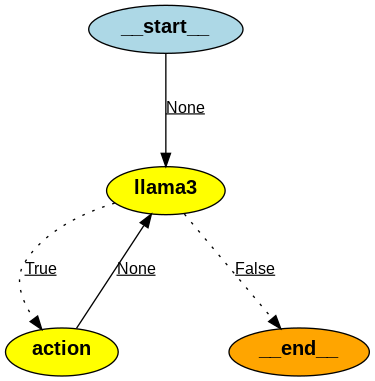

In [65]:
from IPython.display import Image

Image(agent.graph.get_graph().draw_png())

## 5. Use Agent

In [66]:
messages = [HumanMessage(content="Wazzzzzz up LlaMa 3.1?")]

result = agent.graph.invoke({"messages": messages})

In [67]:
result['messages'][-1].content

"Not much, just here and ready to help with any questions or tasks you may have. What's on your mind?"

In [68]:
messages = [HumanMessage(content="What is EBITDA of nvidia?")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'EBITDA', 'args': {'ticker': 'NVDA'}, 'id': 'call_s8q5', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [69]:
result

{'messages': [HumanMessage(content='What is EBITDA of nvidia?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_s8q5', 'function': {'arguments': '{"ticker":"NVDA"}', 'name': 'EBITDA'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 1733, 'total_tokens': 1801, 'completion_time': 0.272, 'prompt_time': 0.445306064, 'queue_time': None, 'total_time': 0.717306064}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b3ae7e594e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-834fe8f3-7817-4126-9561-e6342f9dbe01-0', tool_calls=[{'name': 'EBITDA', 'args': {'ticker': 'NVDA'}, 'id': 'call_s8q5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1733, 'output_tokens': 68, 'total_tokens': 1801}),
  ToolMessage(content='49274998784', name='EBITDA', tool_call_id='call_s8q5'),
  AIMessage(content='The EBITDA of NVIDIA is $49,274,998,784.', response_metadata={'token_usage': {'completion_tokens':

In [70]:
result['messages'][-1].content

'The EBITDA of NVIDIA is $49,274,998,784.'

In [71]:
messages = [HumanMessage(content="What is EBITDA and debt-to-equity ratio of Google?")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'EBITDA', 'args': {'ticker': 'GOOG'}, 'id': 'call_djzn', 'type': 'tool_call'}
Calling Tool: {'name': 'debt_to_equity_ratio', 'args': {'ticker': 'GOOG'}, 'id': 'call_d9g0', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [72]:
result['messages'][-1].content

'Based on the tool call results, the EBITDA of Google is $115,478,003,712 and the debt-to-equity ratio is 8.295.'

In [75]:
messages = [HumanMessage(content="Compare total revenue of Apple and Nvidia.")]

result = agent.graph.invoke({"messages": messages})

Calling Tool: {'name': 'total_revenue', 'args': {'ticker': 'AAPL'}, 'id': 'call_6q5t', 'type': 'tool_call'}
Calling Tool: {'name': 'total_revenue', 'args': {'ticker': 'NVDA'}, 'id': 'call_dpp3', 'type': 'tool_call'}
Tools Execution Complete. Back to the model!


In [76]:
result['messages'][-1].content

"Based on the results, Apple's total revenue is $381,623,009,280, while Nvidia's total revenue is $79,773,999,104. Apple's total revenue is approximately 4.8 times larger than Nvidia's."

## Summary

In this video, I explained how to create simple **tool calling** agent using **LangGraph**. Please feel free to let me know your views in the comments section.